In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import itertools

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

100%|██████████| 170M/170M [00:05<00:00, 32.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512,10)

    def forward(self,x):
        out = self.features(x)
        out = out.view(out.size(0),-1)
        out = self.classifier(out)
        return out

    def _make_layers(self,cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(2,2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size= 3, padding=1), nn.BatchNorm2d(x), nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


In [4]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (output.argmax(1) == target).sum().item()
    return total_loss / len(train_loader.dataset), correct / len(train_loader.dataset)

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += criterion(output, target).item()
            correct += (output.argmax(1) == target).sum().item()
    return total_loss / len(test_loader.dataset), correct / len(test_loader.dataset)

In [5]:

batch_sizes = [64, 128]
learning_rates = [1e-3, 1e-4]
optimizers = ['Adam', 'SGD']
results = []

Training CNN with batch_size=64, lr=0.001, optimizer=Adam
Epoch 1/10 -> Train Loss: 0.0235, Train Acc: 0.4278, Test Loss: 0.0190, Test Acc: 0.5539
Epoch 2/10 -> Train Loss: 0.0149, Train Acc: 0.6596, Test Loss: 0.0188, Test Acc: 0.5985
Epoch 3/10 -> Train Loss: 0.0115, Train Acc: 0.7448, Test Loss: 0.0117, Test Acc: 0.7474
Epoch 4/10 -> Train Loss: 0.0094, Train Acc: 0.7950, Test Loss: 0.0103, Test Acc: 0.7869
Epoch 5/10 -> Train Loss: 0.0078, Train Acc: 0.8336, Test Loss: 0.0104, Test Acc: 0.7809
Epoch 6/10 -> Train Loss: 0.0066, Train Acc: 0.8598, Test Loss: 0.0085, Test Acc: 0.8189
Epoch 7/10 -> Train Loss: 0.0055, Train Acc: 0.8829, Test Loss: 0.0087, Test Acc: 0.8220
Epoch 8/10 -> Train Loss: 0.0045, Train Acc: 0.9041, Test Loss: 0.0078, Test Acc: 0.8409
Epoch 9/10 -> Train Loss: 0.0037, Train Acc: 0.9196, Test Loss: 0.0090, Test Acc: 0.8292
Epoch 10/10 -> Train Loss: 0.0031, Train Acc: 0.9334, Test Loss: 0.0078, Test Acc: 0.8500


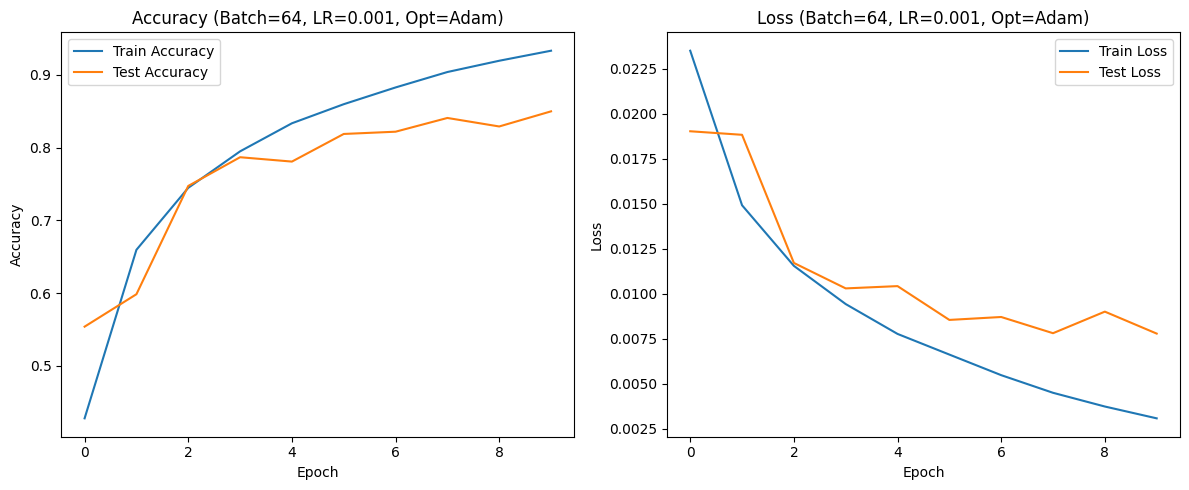

Training CNN with batch_size=64, lr=0.001, optimizer=SGD
Epoch 1/10 -> Train Loss: 0.0228, Train Acc: 0.4724, Test Loss: 0.0187, Test Acc: 0.5737
Epoch 2/10 -> Train Loss: 0.0160, Train Acc: 0.6368, Test Loss: 0.0168, Test Acc: 0.6210
Epoch 3/10 -> Train Loss: 0.0125, Train Acc: 0.7197, Test Loss: 0.0158, Test Acc: 0.6499
Epoch 4/10 -> Train Loss: 0.0096, Train Acc: 0.7895, Test Loss: 0.0147, Test Acc: 0.6773
Epoch 5/10 -> Train Loss: 0.0069, Train Acc: 0.8527, Test Loss: 0.0233, Test Acc: 0.5639
Epoch 6/10 -> Train Loss: 0.0044, Train Acc: 0.9121, Test Loss: 0.0266, Test Acc: 0.5851
Epoch 7/10 -> Train Loss: 0.0026, Train Acc: 0.9521, Test Loss: 0.0171, Test Acc: 0.6813
Epoch 8/10 -> Train Loss: 0.0013, Train Acc: 0.9801, Test Loss: 0.0182, Test Acc: 0.6833
Epoch 9/10 -> Train Loss: 0.0008, Train Acc: 0.9908, Test Loss: 0.0181, Test Acc: 0.6970
Epoch 10/10 -> Train Loss: 0.0005, Train Acc: 0.9951, Test Loss: 0.0224, Test Acc: 0.6648


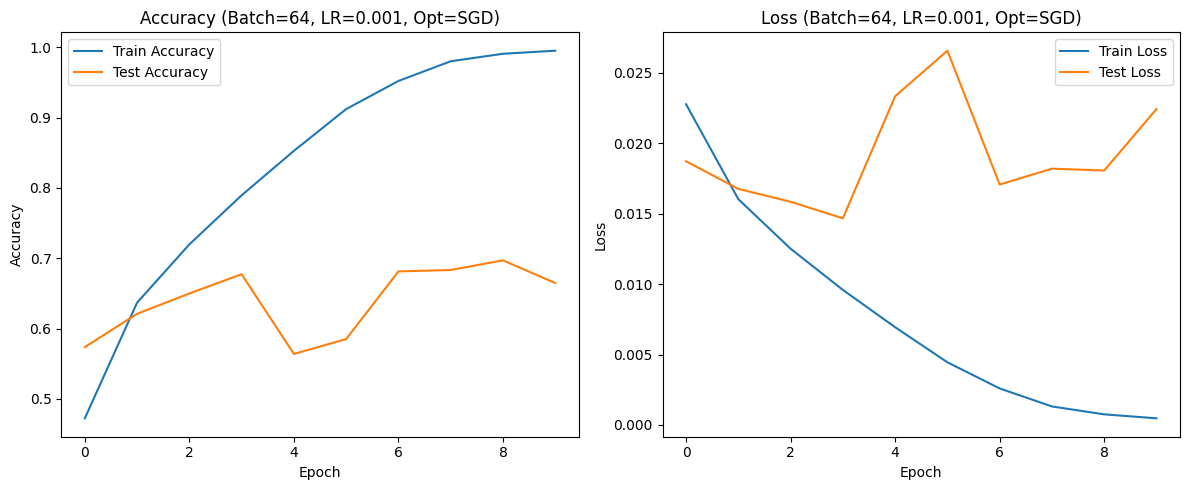

Training CNN with batch_size=64, lr=0.0001, optimizer=Adam
Epoch 1/10 -> Train Loss: 0.0186, Train Acc: 0.5727, Test Loss: 0.0166, Test Acc: 0.6363
Epoch 2/10 -> Train Loss: 0.0118, Train Acc: 0.7349, Test Loss: 0.0122, Test Acc: 0.7361
Epoch 3/10 -> Train Loss: 0.0087, Train Acc: 0.8072, Test Loss: 0.0116, Test Acc: 0.7497
Epoch 4/10 -> Train Loss: 0.0065, Train Acc: 0.8558, Test Loss: 0.0119, Test Acc: 0.7536
Epoch 5/10 -> Train Loss: 0.0048, Train Acc: 0.8941, Test Loss: 0.0112, Test Acc: 0.7753
Epoch 6/10 -> Train Loss: 0.0036, Train Acc: 0.9201, Test Loss: 0.0123, Test Acc: 0.7719
Epoch 7/10 -> Train Loss: 0.0027, Train Acc: 0.9385, Test Loss: 0.0115, Test Acc: 0.7968
Epoch 8/10 -> Train Loss: 0.0021, Train Acc: 0.9531, Test Loss: 0.0124, Test Acc: 0.7915
Epoch 9/10 -> Train Loss: 0.0018, Train Acc: 0.9599, Test Loss: 0.0131, Test Acc: 0.7900
Epoch 10/10 -> Train Loss: 0.0015, Train Acc: 0.9654, Test Loss: 0.0149, Test Acc: 0.7789


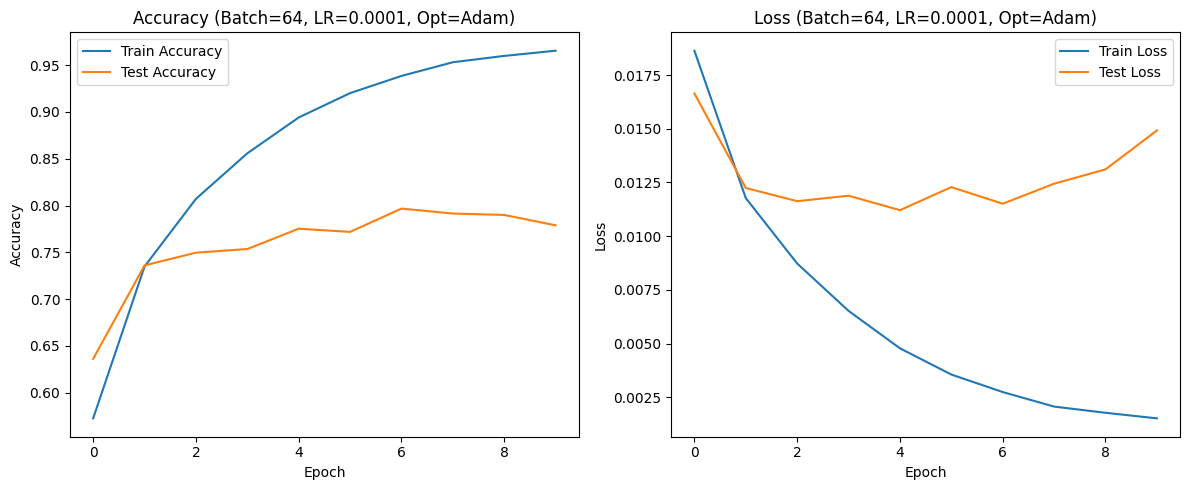

Training CNN with batch_size=64, lr=0.0001, optimizer=SGD
Epoch 1/10 -> Train Loss: 0.0313, Train Acc: 0.2821, Test Loss: 0.0273, Test Acc: 0.3826
Epoch 2/10 -> Train Loss: 0.0255, Train Acc: 0.4203, Test Loss: 0.0242, Test Acc: 0.4455
Epoch 3/10 -> Train Loss: 0.0228, Train Acc: 0.4829, Test Loss: 0.0225, Test Acc: 0.4863
Epoch 4/10 -> Train Loss: 0.0210, Train Acc: 0.5259, Test Loss: 0.0213, Test Acc: 0.5173
Epoch 5/10 -> Train Loss: 0.0196, Train Acc: 0.5595, Test Loss: 0.0205, Test Acc: 0.5363
Epoch 6/10 -> Train Loss: 0.0184, Train Acc: 0.5888, Test Loss: 0.0198, Test Acc: 0.5535
Epoch 7/10 -> Train Loss: 0.0173, Train Acc: 0.6163, Test Loss: 0.0193, Test Acc: 0.5643
Epoch 8/10 -> Train Loss: 0.0163, Train Acc: 0.6420, Test Loss: 0.0187, Test Acc: 0.5753
Epoch 9/10 -> Train Loss: 0.0154, Train Acc: 0.6664, Test Loss: 0.0184, Test Acc: 0.5835
Epoch 10/10 -> Train Loss: 0.0144, Train Acc: 0.6889, Test Loss: 0.0181, Test Acc: 0.5906


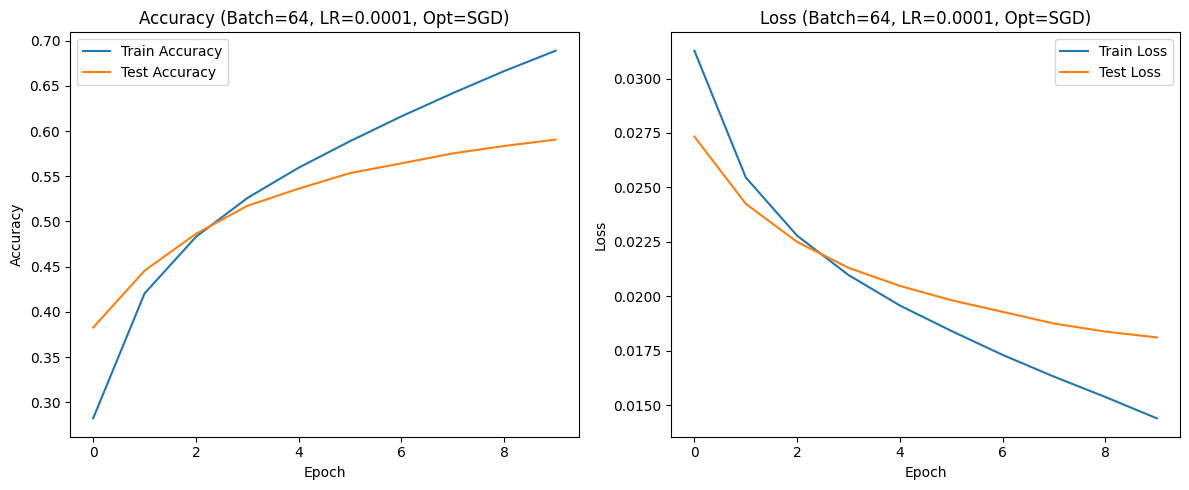

Training CNN with batch_size=128, lr=0.001, optimizer=Adam
Epoch 1/10 -> Train Loss: 0.0115, Train Acc: 0.4392, Test Loss: 0.0112, Test Acc: 0.5158
Epoch 2/10 -> Train Loss: 0.0072, Train Acc: 0.6753, Test Loss: 0.0068, Test Acc: 0.7018
Epoch 3/10 -> Train Loss: 0.0054, Train Acc: 0.7608, Test Loss: 0.0061, Test Acc: 0.7393
Epoch 4/10 -> Train Loss: 0.0044, Train Acc: 0.8098, Test Loss: 0.0051, Test Acc: 0.7789
Epoch 5/10 -> Train Loss: 0.0037, Train Acc: 0.8416, Test Loss: 0.0046, Test Acc: 0.8024
Epoch 6/10 -> Train Loss: 0.0031, Train Acc: 0.8652, Test Loss: 0.0043, Test Acc: 0.8170
Epoch 7/10 -> Train Loss: 0.0025, Train Acc: 0.8885, Test Loss: 0.0049, Test Acc: 0.7969
Epoch 8/10 -> Train Loss: 0.0021, Train Acc: 0.9076, Test Loss: 0.0043, Test Acc: 0.8275
Epoch 9/10 -> Train Loss: 0.0017, Train Acc: 0.9270, Test Loss: 0.0041, Test Acc: 0.8395
Epoch 10/10 -> Train Loss: 0.0014, Train Acc: 0.9394, Test Loss: 0.0066, Test Acc: 0.7843


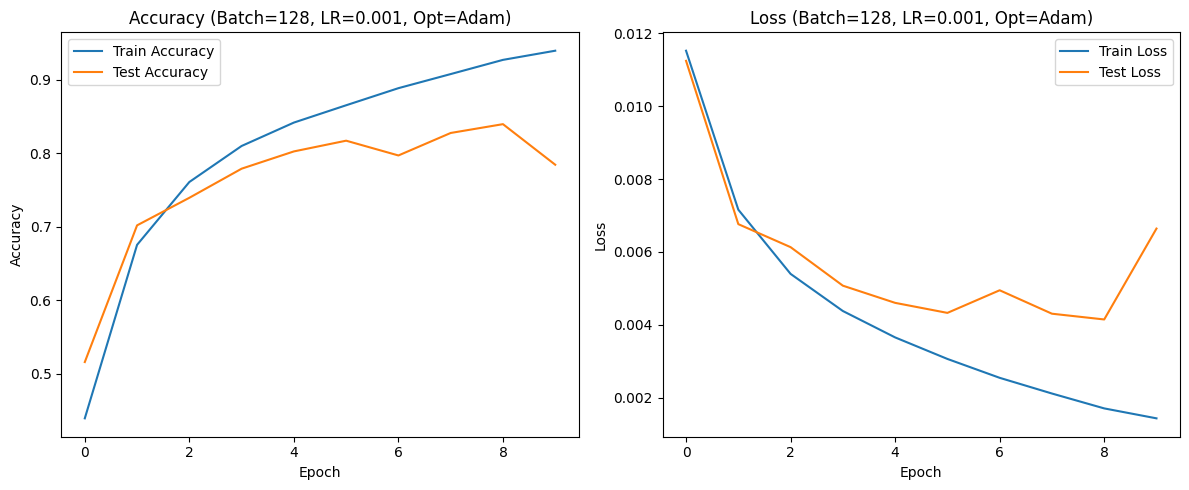

Training CNN with batch_size=128, lr=0.001, optimizer=SGD
Epoch 1/10 -> Train Loss: 0.0124, Train Acc: 0.4224, Test Loss: 0.0103, Test Acc: 0.5238
Epoch 2/10 -> Train Loss: 0.0091, Train Acc: 0.5851, Test Loss: 0.0091, Test Acc: 0.5884
Epoch 3/10 -> Train Loss: 0.0074, Train Acc: 0.6663, Test Loss: 0.0084, Test Acc: 0.6174
Epoch 4/10 -> Train Loss: 0.0060, Train Acc: 0.7382, Test Loss: 0.0083, Test Acc: 0.6279
Epoch 5/10 -> Train Loss: 0.0047, Train Acc: 0.8004, Test Loss: 0.0082, Test Acc: 0.6394
Epoch 6/10 -> Train Loss: 0.0035, Train Acc: 0.8643, Test Loss: 0.0080, Test Acc: 0.6530
Epoch 7/10 -> Train Loss: 0.0023, Train Acc: 0.9232, Test Loss: 0.0091, Test Acc: 0.6396
Epoch 8/10 -> Train Loss: 0.0013, Train Acc: 0.9659, Test Loss: 0.0090, Test Acc: 0.6465
Epoch 9/10 -> Train Loss: 0.0007, Train Acc: 0.9882, Test Loss: 0.0092, Test Acc: 0.6506
Epoch 10/10 -> Train Loss: 0.0004, Train Acc: 0.9971, Test Loss: 0.0096, Test Acc: 0.6525


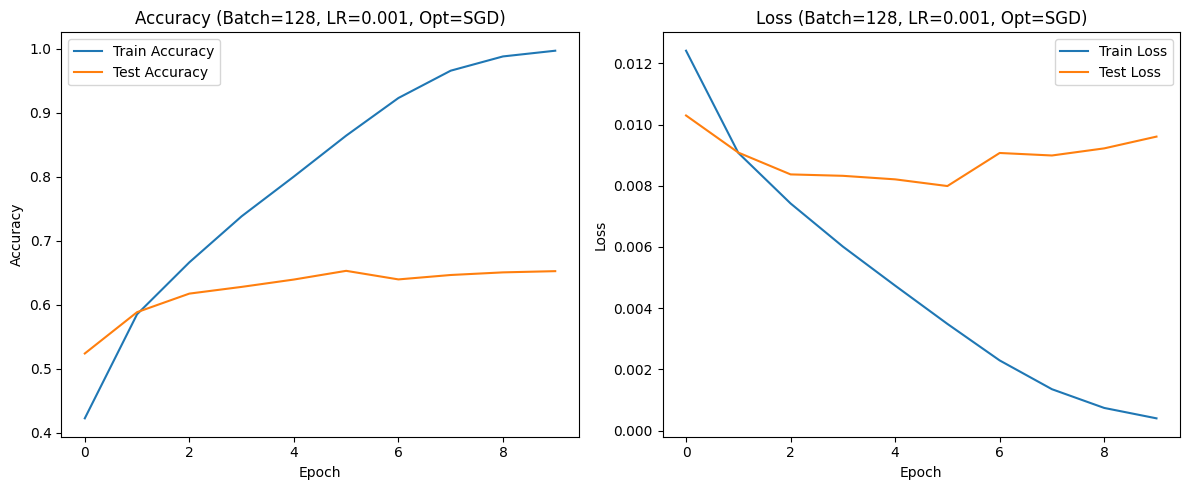

Training CNN with batch_size=128, lr=0.0001, optimizer=Adam
Epoch 1/10 -> Train Loss: 0.0092, Train Acc: 0.5726, Test Loss: 0.0076, Test Acc: 0.6625
Epoch 2/10 -> Train Loss: 0.0058, Train Acc: 0.7371, Test Loss: 0.0061, Test Acc: 0.7313
Epoch 3/10 -> Train Loss: 0.0043, Train Acc: 0.8083, Test Loss: 0.0057, Test Acc: 0.7494
Epoch 4/10 -> Train Loss: 0.0030, Train Acc: 0.8682, Test Loss: 0.0062, Test Acc: 0.7541
Epoch 5/10 -> Train Loss: 0.0021, Train Acc: 0.9055, Test Loss: 0.0063, Test Acc: 0.7627
Epoch 6/10 -> Train Loss: 0.0014, Train Acc: 0.9361, Test Loss: 0.0079, Test Acc: 0.7383
Epoch 7/10 -> Train Loss: 0.0011, Train Acc: 0.9504, Test Loss: 0.0070, Test Acc: 0.7751
Epoch 8/10 -> Train Loss: 0.0009, Train Acc: 0.9613, Test Loss: 0.0077, Test Acc: 0.7620
Epoch 9/10 -> Train Loss: 0.0008, Train Acc: 0.9656, Test Loss: 0.0083, Test Acc: 0.7591
Epoch 10/10 -> Train Loss: 0.0006, Train Acc: 0.9716, Test Loss: 0.0076, Test Acc: 0.7766


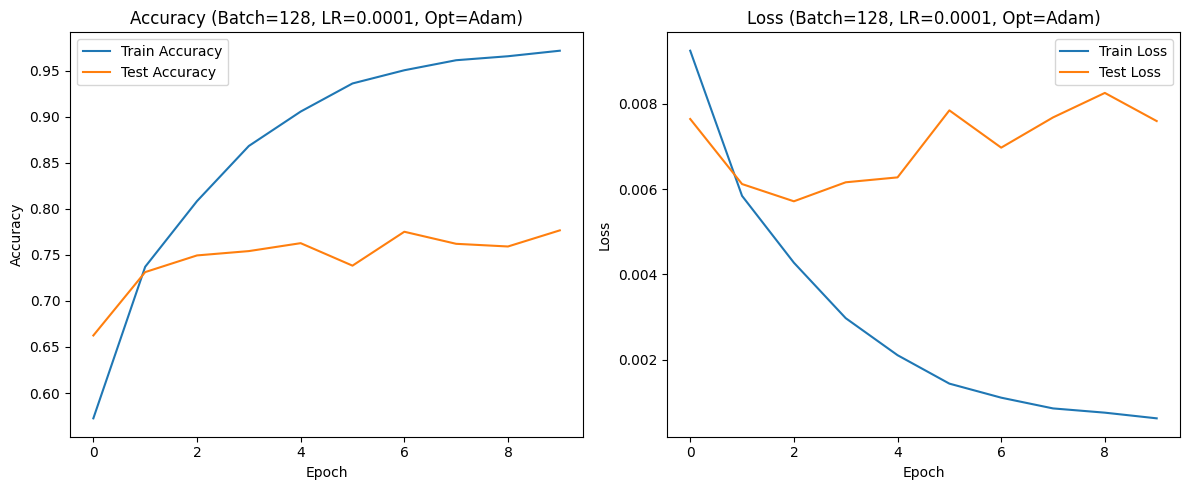

Training CNN with batch_size=128, lr=0.0001, optimizer=SGD
Epoch 1/10 -> Train Loss: 0.0169, Train Acc: 0.2189, Test Loss: 0.0154, Test Acc: 0.3018
Epoch 2/10 -> Train Loss: 0.0143, Train Acc: 0.3549, Test Loss: 0.0138, Test Acc: 0.3727
Epoch 3/10 -> Train Loss: 0.0129, Train Acc: 0.4169, Test Loss: 0.0129, Test Acc: 0.4151
Epoch 4/10 -> Train Loss: 0.0120, Train Acc: 0.4546, Test Loss: 0.0122, Test Acc: 0.4454
Epoch 5/10 -> Train Loss: 0.0114, Train Acc: 0.4889, Test Loss: 0.0117, Test Acc: 0.4621
Epoch 6/10 -> Train Loss: 0.0108, Train Acc: 0.5127, Test Loss: 0.0114, Test Acc: 0.4814
Epoch 7/10 -> Train Loss: 0.0104, Train Acc: 0.5358, Test Loss: 0.0111, Test Acc: 0.4916
Epoch 8/10 -> Train Loss: 0.0100, Train Acc: 0.5546, Test Loss: 0.0108, Test Acc: 0.5032
Epoch 9/10 -> Train Loss: 0.0096, Train Acc: 0.5754, Test Loss: 0.0106, Test Acc: 0.5125
Epoch 10/10 -> Train Loss: 0.0093, Train Acc: 0.5907, Test Loss: 0.0104, Test Acc: 0.5228


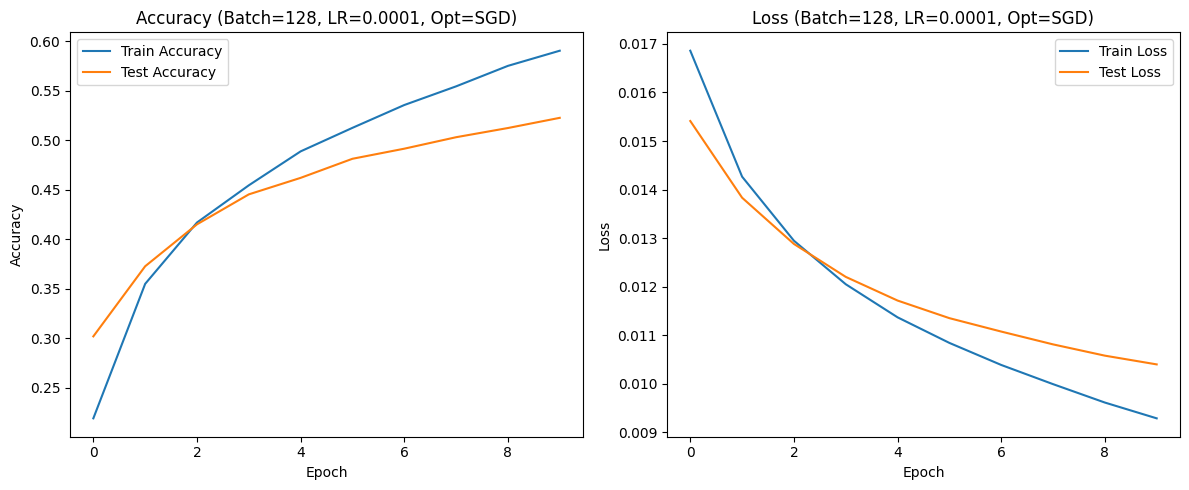

In [7]:
for batch_size, learning_rate, optimizer_name in itertools.product(batch_sizes, learning_rates, optimizers):
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        model = VGG('VGG16').to(device)
        criterion = nn.CrossEntropyLoss()

        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        elif optimizer_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=learning_rate)

        print(f"Training CNN with batch_size={batch_size}, lr={learning_rate}, optimizer={optimizer_name}")

        train_losses, test_losses = [], []
        train_accs, test_accs = [], []

        for epoch in range(10):
            train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
            test_loss, test_acc = evaluate(model, test_loader, criterion, device)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accs.append(train_acc)
            test_accs.append(test_acc)

            print(f"Epoch {epoch+1}/10 -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

        # Store results
        results.append((batch_size, learning_rate, optimizer_name, max(test_accs)))

        # Plot accuracy and loss for each combination
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_accs, label="Train Accuracy")
        plt.plot(test_accs, label="Test Accuracy")
        plt.title(f"Accuracy (Batch={batch_size}, LR={learning_rate}, Opt={optimizer_name})")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_losses, label="Train Loss")
        plt.plot(test_losses, label="Test Loss")
        plt.title(f"Loss (Batch={batch_size}, LR={learning_rate}, Opt={optimizer_name})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.tight_layout()
        plt.show()